In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


path = '../input/digit-recognizer'

In [3]:
sample_sub_df = pd.read_csv(path+'/sample_submission.csv')
train_df = pd.read_csv(path+'/train.csv')
test_df = pd.read_csv(path+'/test.csv')

In [4]:
sample_sub_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [5]:
train_df.head()  # label, input = 784(28, 28, 1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df.shape

(42000, 785)

[8 6 0 0 8 9 8 5]
shape:  torch.Size([8, 1, 28, 28])


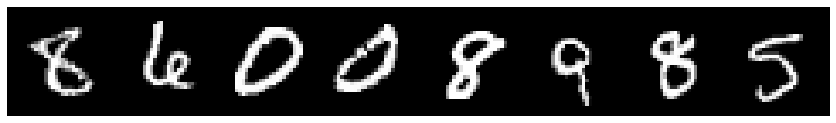

In [7]:
random_n = np.random.randint(len(train_df),size=8)
train_0 = torch.Tensor(train_df.iloc[random_n, 1:].values/255.0).reshape(-1, 28, 28).unsqueeze(1)
grid = make_grid(train_0, nrow=8)

#  visualize
print(train_df.iloc[random_n, 0].values)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print('shape: ', train_0.shape)  # nSamples x nChannels x Height x Width

In [8]:
class MNIST(Dataset):
    """
    自作Dataset
    len, getitem が必要
    """
    def __init__(self, dataframe):
        df = dataframe
        self.n_pixels = 784
        
        if len(df.columns) == self.n_pixels:
            # test data　次の方法で次元を増やしている。
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))
        ])
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [9]:
from torchvision.models.resnet import ResNet, BasicBlock

# input = (1, 28, 28) なので
# デフォルトのチャンネル数は 3 (RGB) なので conv1　をいじる.
# 最終fc層の output = n_classes にする. input = 784 * 784

class mResNet34(ResNet):
    def __init__(self):
        super(mResNet34, self).__init__(block=BasicBlock, layers=[3, 4, 6, 3], num_classes=10) # Based on ResNet34
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3, bias=False)
        self.fc    = nn.Linear(in_features=784, out_features=10)

model = mResNet34()
print('mResNet34: ', model)

mResNet34:  mResNet34(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

In [10]:
# training
